In [5]:
import os

# Path to your dataset
dataset_path = r"E:\CLD_project\Final_CLD_data"

# Subdirectories for train, val, and test
splits = ['train', 'val', 'test']

# Dictionary to store image counts
image_counts = {}

for split in splits:
    split_path = os.path.join(dataset_path, split)
    if os.path.exists(split_path):
        image_counts[split] = {}
        for cls in os.listdir(split_path):
            class_folder = os.path.join(split_path, cls)
            if os.path.isdir(class_folder):
                image_counts[split][cls] = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Print results
for split, classes in image_counts.items():
    print(f"\n{split.upper()} SET:")
    for cls, count in classes.items():
        print(f"  Class '{cls}': {count} images")



TRAIN SET:
  Class 'Cerscospora': 25000 images
  Class 'Healthy': 24999 images
  Class 'Leaf rust': 25000 images
  Class 'Miner': 25000 images
  Class 'Phoma': 25000 images

VAL SET:
  Class 'Cerscospora': 5000 images
  Class 'Healthy': 5000 images
  Class 'Leaf rust': 5000 images
  Class 'Miner': 5000 images
  Class 'Phoma': 5000 images

TEST SET:
  Class 'Cerscospora': 769 images
  Class 'Healthy': 1899 images
  Class 'Leaf rust': 835 images
  Class 'Miner': 1699 images
  Class 'Phoma': 658 images


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torchvision.models import ResNet50_Weights

import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# ✅ Set Paths
DATASET_PATH = "E:\CLD_project\Final_CLD_data"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=transform)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 124999, Validation: 25000, Test: 5860


In [3]:
# ✅ Load Pretrained ResNet50
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))  # Adjust output layer

model = model.to(DEVICE)

In [4]:
# ✅ Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to store metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []


In [6]:
# ✅ Training Loop
def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct/total)  # Show live metrics
        
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
        val_acc, val_loss = evaluate(model, val_loader)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

In [7]:
# ✅ Evaluation Function
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total, total_loss / len(loader)

In [8]:
# ✅ Start Training
train(model, train_loader, val_loader, EPOCHS)

Epoch 1/3: 100%|██████████| 3907/3907 [51:46<00:00,  1.26it/s, acc=0.988, loss=0.00521]    


Epoch 1/3 | Train Acc: 0.9878 | Val Acc: 0.9976 | Loss: 0.0414 | Val Loss: 0.0075


Epoch 2/3: 100%|██████████| 3907/3907 [54:30<00:00,  1.19it/s, acc=0.997, loss=2.95e-5] 


Epoch 2/3 | Train Acc: 0.9975 | Val Acc: 0.9988 | Loss: 0.0087 | Val Loss: 0.0039


Epoch 3/3: 100%|██████████| 3907/3907 [49:58<00:00,  1.30it/s, acc=0.998, loss=0.000158]


Epoch 3/3 | Train Acc: 0.9983 | Val Acc: 0.9984 | Loss: 0.0058 | Val Loss: 0.0057


In [9]:
# Save ResNet50
torch.save(model.state_dict(), "resnet50_coffee.pth")


In [10]:
# ✅ Evaluate on Test Data
test_acc, test_loss = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:}")

Test Accuracy: 0.9998293515358362


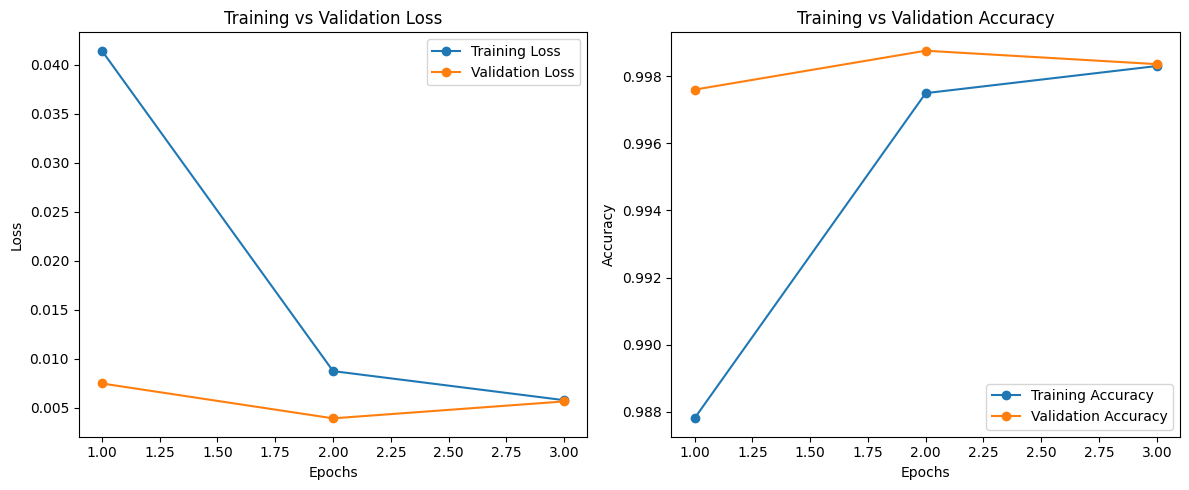

In [11]:
# ✅ Plot Training History
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracies 
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label="Training Accuracy", marker="o")
plt.plot(range(1, EPOCHS + 1), val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()